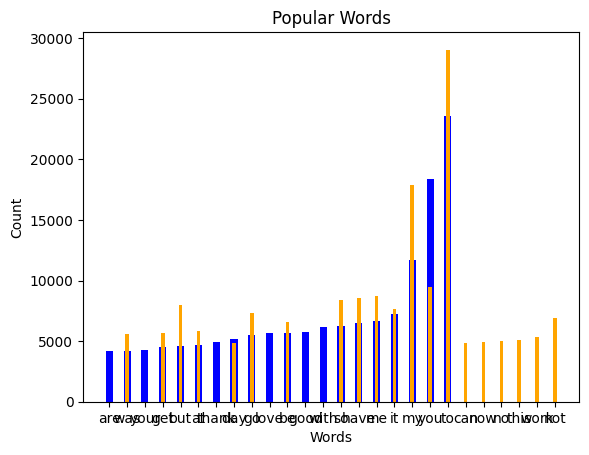

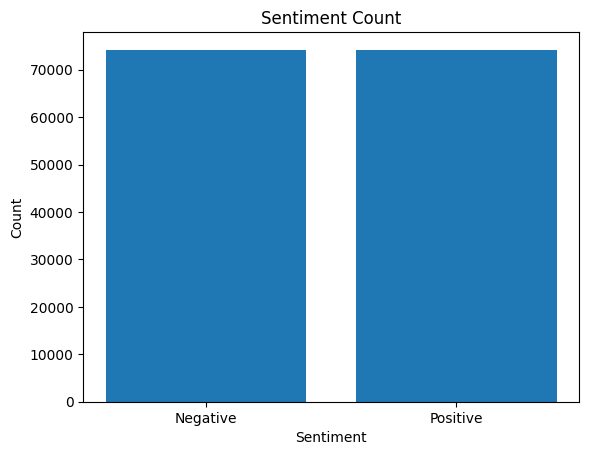

In [15]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from collections import Counter
import nltk

csv_data = pd.read_csv("/kaggle/input/ai-2-deep-learning-for-nlp-homework-1/train_dataset.csv")

arr = csv_data.to_numpy()

def preprocess_data(arr):
    link_user_regex = re.compile(r'(www\.\w*\.\w*)|(@\w*)|(https?://(\w|[./])*)\s*') #remove links and usernames
    remove_html_regex = re.compile(r'&\w*(;|\b)') #remove html symbols
    remove_nonascii_regex = re.compile(r'[^ -~]+')
    remove_symbols_regex = re.compile(r'[\|{}_,/.\'\"`<>!\\@#$%^\(\)\*\-=\+/\?;:~\[\]]+') #remove symbols
    remove_numbers_regex = re.compile(r'(\b[a-zA-Z]\b)|([0-9]+)') #remove numbers/letters
    remove_hashtags_regex = re.compile(r'\b#\w+\b')
    ty_regex = re.compile(r'\bty\b')
    stopwrd = ('the','and','of','in','day','is','it','on','that','for','just')
    stopwrd_dict = Counter(stopwrd)
    for i in range(len(arr)):
        row = arr[i]
        row[1] = ' '.join([word for word in row[1].split() if word.lower() not in stopwrd_dict])
        row[1] = remove_nonascii_regex.sub(" ",row[1])
        row[1] = remove_hashtags_regex.sub(" ",row[1])
        row[1] = link_user_regex.sub(" ",row[1])
        row[1] = remove_html_regex.sub(" ",row[1])
        row[1] = remove_symbols_regex.sub(" ",row[1])
        row[1] = remove_numbers_regex.sub(" ",row[1])
        row[1] = ty_regex.sub("thank",row[1])
    return arr

def stemmer(arr):
    stemmer = nltk.stem.SnowballStemmer("english")
    for i in range(len(arr)):
        row = arr[i]
        sentence = []
        for word in row[1].split():
            sentence.append(stemmer.stem(word))
        row[1] = " ".join(sentence)
    return arr

def remove_empty(arr):
    new_arr = []
    for i in range(len(arr)):
        if arr[i][1] == "":
            continue
        new_arr.append(arr[i])
    return np.array(new_arr)


arr = preprocess_data(arr)
arr = stemmer(arr)

pos_count = 0
for i in range(len(arr)):
    #print(arr[i][1])
    pos_count += arr[i][2]

L_pos = []
L_neg = []
for i in range(len(arr)):
    if arr[i][2] == 1:
        L_pos += arr[i][1].split()
    else:
        L_neg += arr[i][1].split()
words_pos = np.array(L_pos)
words_neg = np.array(L_neg)

(words_pos,counts_pos) = np.unique(words_pos,return_counts=True)
(words_neg,counts_neg) = np.unique(words_neg,return_counts=True)
pos_pop_words = sorted(list(zip(words_pos,counts_pos)),key= lambda tuple: tuple[1])
neg_pop_words = sorted(list(zip(words_neg,counts_neg)),key= lambda tuple: tuple[1])
words_pos,counts_pos = zip(*pos_pop_words[-20:])
words_neg,counts_neg = zip(*neg_pop_words[-20:])
plt.figure()
plt.bar(words_pos,counts_pos,0.4,color="blue")
plt.bar(words_neg,counts_neg,0.2,color="orange")
plt.title("Popular Words")
plt.xlabel("Words")
plt.ylabel("Count")
plt.savefig("/kaggle/working/pop_words.png")

neg_count = len(arr) - pos_count
plt.figure()
plt.bar(["Negative","Positive"],[neg_count,pos_count])
plt.title("Sentiment Count")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.savefig("/kaggle/working/sentiment_count.png")

In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve
from sklearn.metrics import f1_score,precision_score,recall_score,accuracy_score
import sklearn.metrics
import pandas as pd
import matplotlib.pyplot as plt
import random
import numpy as np

train_data = pd.read_csv("/kaggle/input/ai-2-deep-learning-for-nlp-homework-1/train_dataset.csv")
val_data = pd.read_csv("/kaggle/input/ai-2-deep-learning-for-nlp-homework-1/val_dataset.csv")

def load_data(data):
    arr = data.to_numpy()
    arr = preprocess_data(arr)
    arr = stemmer(arr)
    return arr

def create_input(vectorizer,data):
    tweets = data[:,1]
    gold_labels = data[:,2]
    gold_labels = gold_labels.astype('int')
    features = vectorizer.transform(tweets)
    return (features,gold_labels)

def vectorize_input(vectorizer,data):
    tweets = data[:,1]
    features = vectorizer.transform(tweets)
    return features

def train_model(vectorizer,data):
    random.seed()
    rng = np.random.RandomState(random.randint(0,1000000))
    tweets = data[:,1]
    gold_labels = data[:,2]
    gold_labels = gold_labels.astype('int')
    features = vectorizer.fit_transform(tweets)
    #log_regr = LogisticRegression()
    #param_grid = [{
    #    'penalty' : ['elasticnet'],
    #    'solver': ['saga'],
    #    'l1_ratio': np.linspace(0,1,10)
    #}]
    #clf = GridSearchCV(log_regr,param_grid = param_grid,n_jobs=-1,cv=3,verbose=3).fit(features,gold_labels)
    #print(clf.best_estimator_)
    clf = LogisticRegression(random_state=rng,n_jobs=-1,solver='saga').fit(features,gold_labels)
    return clf

def create_learning_curve(clf,vectorizer,data):
    tweets = data[:,1]
    labels = data[:,2]
    labels = labels.astype('int')
    features = vectorizer.fit_transform(tweets)
    train_size, train_scores, test_scores = learning_curve(clf,features,labels,cv=3)
    train_mean = np.mean(train_scores,axis=1)
    test_mean = np.mean(test_scores,axis=1)
    plt.plot(train_size,train_mean,color='blue')
    plt.plot(train_size,test_mean,color='orange')
    plt.xlabel('Data size')
    plt.ylabel('Score')
    plt.legend(['Train Score', 'Test Score'])
    plt.savefig("/kaggle/working/learning_curve.png")
    

train = load_data(train_data)
train = remove_empty(train)
val = load_data(val_data)

vectorizer = TfidfVectorizer(lowercase=False,sublinear_tf=True,ngram_range = (1,6),min_df=2)

clf = train_model(vectorizer,train)

features_val,val_gold_labels = create_input(vectorizer,val)

pred_labels = clf.predict(features_val)

print("F1: ",f1_score(val_gold_labels,pred_labels))
print("Accuracy: ",accuracy_score(val_gold_labels,pred_labels))
print("Precision: ",precision_score(val_gold_labels,pred_labels))
print("Recall: ",recall_score(val_gold_labels,pred_labels))

clf = LogisticRegression(n_jobs=-1,solver='saga')
create_learning_curve(clf,vectorizer,train)

F1:  0.8035444234404536
Accuracy:  0.8038965940183036
Precision:  0.80502817101463
Recall:  0.8020661351950563


KeyboardInterrupt: 

In [ ]:
train_data = pd.read_csv("/kaggle/input/ai-2-deep-learning-for-nlp-homework-1/train_dataset.csv")
test_data = pd.read_csv("/kaggle/input/ai-2-deep-learning-for-nlp-homework-1/test_dataset.csv")

train = load_data(train_data)
train = remove_empty(train)
test = load_data(test_data)

vectorizer = TfidfVectorizer(lowercase=False,sublinear_tf=True,ngram_range = (1,6),min_df=2)

clf = train_model(vectorizer,train)
test_features = vectorize_input(vectorizer,test)

pred_labels = clf.predict(test_features)

L = []
for i in range(len(pred_labels)):
    L.append([test[i,0],pred_labels[i]])

arr = np.array(L)
columns = ['ID','Label']
dataframe = pd.DataFrame(data=arr,columns=columns)

dataframe.to_csv("/kaggle/working/submission.csv",index=False)